# Homework 3 - Linear and Logistic Regressions
## CSCI 5622 - Fall 2021
***
**Name**: $<$insert name here$>$
***

This assignment is due on Canvas by **11.59 PM on Thursday, October 28th**.
Submit only this Jupyter notebook to Canvas.  Do not compress it using tar, rar, zip, etc.
Your solutions to analysis questions should be done in Markdown directly below the associated question.
Remember that you are encouraged to discuss the problems with your classmates and instructors,
but **you must write all code and solutions on your own**, and list any people or sources consulted.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle, gzip
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Problem 1: Linear Regression (40 points)
For this problem we will be using the following datasets

In [2]:
class CloudData:
    def __init__(self):
        # Data from: https://archive.ics.uci.edu/ml/datasets/Cloud
        data = np.fromfile("data/cloud.data", sep = " ").reshape((1024, 10))
        y = data[:, 6]
        X = np.delete(data, 6, axis = 1)
        
        self.train_x = X[:800]
        self.train_y = y[:800]
        
        self.test_x = X[800:]
        self.test_y = y[800:]
        
class ForestData:
    def __init__(self):
        # Data from: http://archive.ics.uci.edu/ml/datasets/Forest+Fires
        data = pd.read_csv("data/forestfires.csv")
        data = data.sample(frac = 1).reset_index(drop = True).drop(columns = ["month", "day"])
        data["area"] = np.log(data["area"] + 1)
        X = data.drop(columns = "area").values
        y = data["area"].values
        
        self.train_x = X[:400]
        self.train_y = y[:400]
        
        self.test_x = X[400:]
        self.test_y = y[400:]
cloud_data = CloudData()
forest_data = ForestData()

We have seen that Ridge regression adds a regularization term to the least square using the L2 norm.
Ridge regression is part of scikit-learn package ([read more](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html))
but we will be building our own implementation. You can test your implementation against scikit's.

The objective of Ridge regression is to minimize:

\begin{align}
\frac{1}{N}\sum_{i=1}^{N} ||y_i-\mathbf{w}^T x_i-b||^2 + \alpha||\mathbf{w}||^2
\end{align}

where $\mathbf{w}$ denotes the set of parameters for the linear regression model, $b$ the intercept, $\alpha$ is the trade-off regularization parameter, and $N$ the number of samples

Luckily for us, Ridge regression has closed form solutions for $\mathbf w$ and $b$.

Let $X$ be the $N\times d$ matrix whose rows are the training samples $(x_i)_{i\leq N}$ and $Y=(y_i)_{i\leq N}$ the target values.

First, we start by centering the features (columns of X) by subtracting the mean of the column to get centered matrix $\hat{X}$. Then the solution for the minimization is (trust me):

\begin{align}
&\mathbf{w^*} = (\hat{X}^T\hat{X} + \alpha I)^{-1}\hat{X}^TY \\
&b^* = \frac{1}{N} \sum_{i}^{i=N} (y_i - \mathbf{w^*}^T x_i)
\end{align}
(Note that the samples in $b^*$ are not centered)

A common practice is to scale or normalize (usually normalize) the features before fitting the model. It allows a _fair_ treatment of different features.
You are allowed to use scikit's `StandardScaler` to do the normalization (yes, a thing called scaler is normalizing. Don't @ me, @ sklearn). Do not forget to run the same transformation on the test data before running the prediction.

- 1.1 *[5 points]* Complete the `fit` and `evaluate` methods following the docstring description.

In [3]:
class Ridge(object):

    def __init__(self, alpha, normalize = False):
        """
        :param alpha: regularization parameter
        :param normalize: boolean whether to normalize the features or not
        """

        self.alpha = alpha # our tuning / regularization parameter
        self.coef_ = None # our weights vector, w (in formulae above)
        self.intercept = None # our intercept parameter, b (in formulae above)
        self.normalize = normalize # boolean whether to normalize the features or not
        self.scaler = StandardScaler() # method by which to normalize the features (depends on self.normalize)

    def fit(self, X, y):
        """
        Fit the ridge model, train it using the provided data
        Calculate the number of non-zero coefficients in the model weights and the norm using np.linalg.norm
        :param X: training features (n_samples, n_features)
        :param y: target values (n_samples)
        :return: tuple (number of non-zeros coefficients of w, norm of w)
        """
        num_nonzero_coefs, coef_norm = 0, 0
        # Workspace 1.1.a
        # TO DO: compute w and b and store them in self.coef_ and self.intercept
        # HINT: use self.scaler first, if and only if self.normalize is True
        #BEGIN 
        #code here
        
        if self.normalize:
            X = self.scaler.fit_transform(X)
        
        X_centered = np.zeros(np.shape(X))
        
        col_means = [np.mean(X, axis=0)[i] for i in range(len(X[0]))]
        
        for row in range(len(X)):
            for col in range(len(X[0])):
                X_centered[row][col] = X[row][col] - col_means[col]
                
        X_t_X = np.transpose(X_centered) @ X_centered
        alpha_I = self.alpha * np.identity(np.shape(X)[1])
        inverse_term = np.linalg.inv(X_t_X + alpha_I)
        
        w_star = inverse_term @ np.transpose(X_centered) @ y
        
        self.coef_ = w_star
        
        N = len(X) # n_samples
        b_star = 0
        for i in range(N):
            b_star += y[i] - (np.transpose(w_star) @ np.transpose(X[i]))
            
        b_star /= N
        self.intercept = b_star
        
        num_nonzero_coefs = np.count_nonzero(w_star)
        coef_norm = np.linalg.norm(w_star)
        
        #END
        return num_nonzero_coefs, coef_norm

    def evaluate(self, test_x, test_y):
        """
        Compute Root mean square error (RMSE) between the predicted values and the actual values  of the test data
        :param test_x: test features
        :param test_y: test target
        :return: RMSE
        """
        
        if self.normalize:
            test_x = self.scaler.transform(test_x)
        
        # Workspace 1.1.b
        #BEGIN 
        #code here
        
        predicted_values = []
        
        for row in test_x:
            y_hat = np.sum(self.coef_ * row) + self.intercept
            predicted_values.append(y_hat)
            
        # to get RMSE, do (predicted - actual)^2, sum across num_samples, divide that by num_samples, take square root of all of that
        RMSE = 0
        for i in range(len(test_y)):
            RMSE += (predicted_values[i] - test_y[i])**2
            
        RMSE /= len(test_y)
        
        root_mean_squared_error = np.sqrt(RMSE)
        
        #END
        return root_mean_squared_error

In [4]:
# Tests cells, do not remove
# Should run without errors
sanity_X = np.array([[1.55143777, 0.2644804, 0.0995576 ],
              [0.22541014,  1.6967911,  -0.45701382],
              [0.12528546, -1.44263567, 0.7017054 ],
              [-1.30567135, -0.86010032, -1.13522536]])
sanity_y = np.array([ 136.70039877, 10.1003086, 44.67363091, -221.48398972])
# Test unnormalized ridge
coef_raw = np.array([67.3816571, 12.4267024, 46.63028522])
intercept_raw = -7.2683820675025785
reg = Ridge(alpha=2, normalize=False)
reg.fit(sanity_X,sanity_y)
assert np.alltrue(np.isclose(coef_raw, reg.coef_, atol=1e-5)) and np.isclose(intercept_raw, reg.intercept, atol=1e-5)

In [5]:
# test normalized ridge
coef_norm = np.array([59.85861897, 18.28561265, 48.08714515])
intercept_norm = -7.502412860000002
reg = Ridge(alpha=2, normalize=True)
reg.fit(sanity_X,sanity_y)
assert np.alltrue(np.isclose(coef_norm, reg.coef_, atol=1e-5)) and np.isclose(intercept_norm, reg.intercept, atol=1e-5)

- 1.2 *[5 points]* For each of the datasets (cloud_data and forest_data from the beginning of this notebook), produce 3 plots as a function of alpha that compare normalized versus non-normalized Ridge:
    - The number non-zero coefficients
    - The norm of $\mathbf w$
    - The test RMSE (Root Mean Squared Error)
Use $\alpha = 1, 50, 100, 200, 1000$.

To produce multiple plots in the same figure, see the examples [here](https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html)

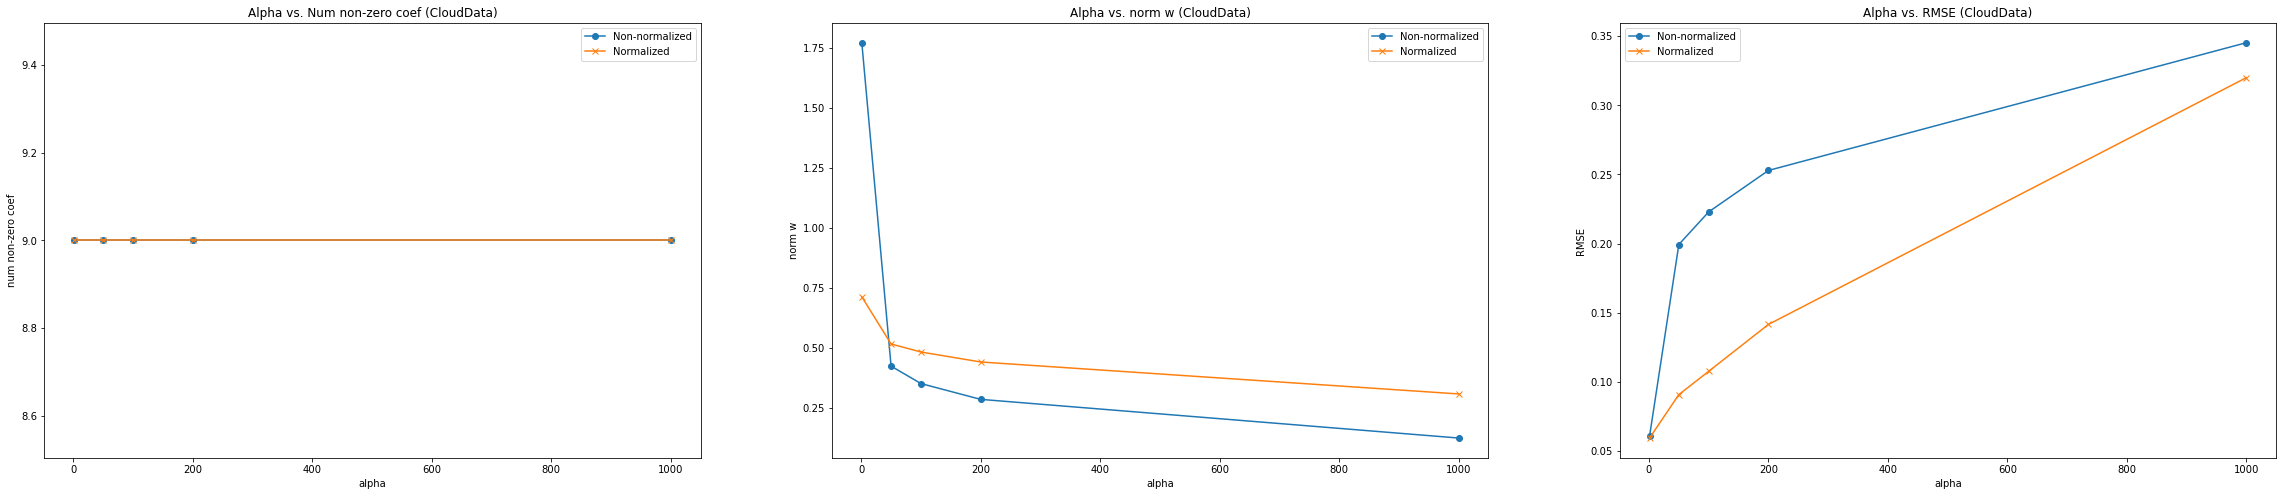

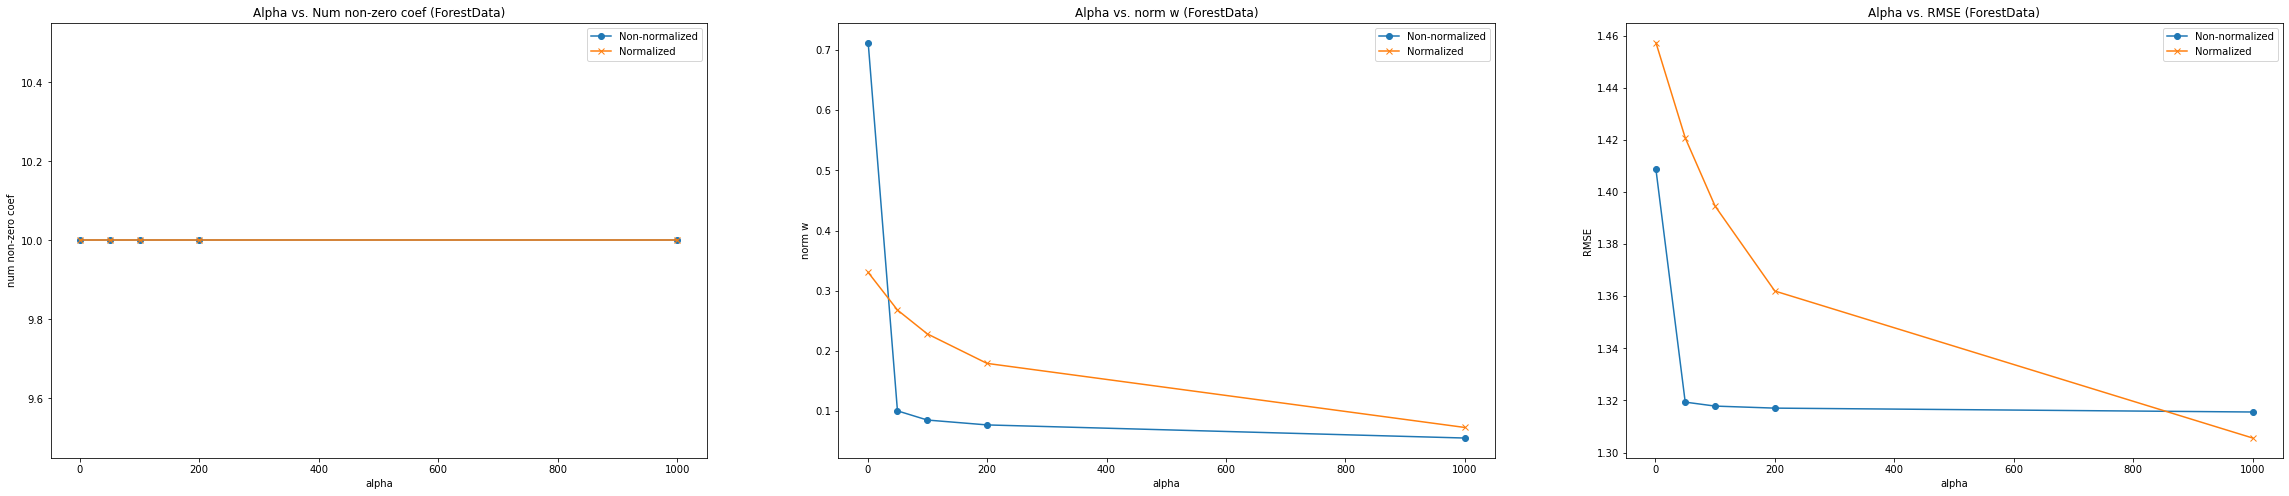

In [6]:
alphas = [1, 50, 100, 200, 1000]
# Workspace 1.2
#BEGIN 
#code here

for dataset in [cloud_data, forest_data]:
    
    non_zero_coef = {
        'regular': [],
        'normalized': []
    }
    
    norm_w = {
        'regular': [],
        'normalized': []
    }
    
    RMSE = {
        'regular': [],
        'normalized': []
    }
    
    for alpha in alphas:
        ridge = Ridge(alpha=alpha, normalize=False)
        non_zero_coef_curr, norm_w_curr = ridge.fit(dataset.train_x, dataset.train_y)
        RMSE_curr = ridge.evaluate(dataset.test_x, dataset.test_y)
        
        non_zero_coef['regular'].append(non_zero_coef_curr)
        norm_w['regular'].append(norm_w_curr)
        RMSE['regular'].append(RMSE_curr)
        
        ridge_norm = Ridge(alpha=alpha, normalize=True)
        non_zero_coef_curr, norm_w_curr = ridge_norm.fit(dataset.train_x, dataset.train_y)
        RMSE_curr = ridge_norm.evaluate(dataset.test_x, dataset.test_y)
        
        non_zero_coef['normalized'].append(non_zero_coef_curr)
        norm_w['normalized'].append(norm_w_curr)
        RMSE['normalized'].append(RMSE_curr)
    
    
    fig, ax = plt.subplots(1, 3, figsize=(40, 8))
    
    ax[0].plot(alphas, non_zero_coef['regular'], marker='o', label='Non-normalized')
    ax[0].plot(alphas, non_zero_coef['normalized'], marker='x', label='Normalized')
    ax[0].set_xlabel('alpha')
    ax[0].set_ylabel('num non-zero coef')
    ax[0].set_title(f'Alpha vs. Num non-zero coef ({dataset.__class__.__name__})')
    ax[0].legend()
    
    ax[1].plot(alphas, norm_w['regular'], marker='o', label='Non-normalized')
    ax[1].plot(alphas, norm_w['normalized'], marker='x', label='Normalized')
    ax[1].set_xlabel('alpha')
    ax[1].set_ylabel('norm w')
    ax[1].set_title(f'Alpha vs. norm w ({dataset.__class__.__name__})')
    ax[1].legend()
    
    ax[2].plot(alphas, RMSE['regular'], marker='o', label='Non-normalized')
    ax[2].plot(alphas, RMSE['normalized'], marker='x', label='Normalized')
    ax[2].set_xlabel('alpha')
    ax[2].set_ylabel('RMSE')
    ax[2].set_title(f'Alpha vs. RMSE ({dataset.__class__.__name__})')
    ax[2].legend()
        
#END

Based on the results from previous questions, you should have noticed that the interpretation of Ridge regression is not an easy task.
One way to solve that is to use a regularization that adds _sparsity_ to $\mathbf w$ and excludes less important features.
That's what Lasso regression is about.

Lasso uses $l_1$ norm in the regularization term and minimizes:
\begin{align}
\frac{1}{2N}\sum_i ||y_i-\mathbf{w}^t x_i -b||^2 + \alpha||\mathbf{w}||_1
\end{align}

It is part of scikit package ([more details](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html))
and you're free to compare your implementation to scikit's.

Unfortunately, there is no closed form solution for Lasso. Instead, we have powerful algorithms to optimize it.
We will be using lasso-path solver from scikit-learn for our implementation to find $\mathbf w^*$
([see more](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.lasso_path.html#sklearn.linear_model.lasso_path)).
(Note that `lasso_path` takes a list of $\alpha$ in the argument `alphas` and not a scalar.)

Similar to Ridge's, $ \mathbf w^* $ is computed using lasso_path with the centered features $\hat{X}$.
Once $\mathbf w^*$ is found, $b^*$ uses the same formula from Ridge regression.

1.3 *[5 points]* Complete the Lasso class in the same way Ridge class was created. (You may use inheritance for a concise code.)

In [7]:
from sklearn.linear_model import lasso_path


class Lasso(object):
    def __init__(self, alpha, normalize = False):
        """
        :param alpha: regularization parameter
        :param normalize: boolean whether to normalize the features or not
        """

        self.alpha = alpha # our tuning / regularization parameter
        self.coef_ = None # our weights vector, w (in formulae above)
        self.intercept = None # our intercept parameter, b (in formulae above)
        self.normalize = normalize # boolean whether to normalize the features or not
        self.scaler = StandardScaler() # method by which to normalize the features (depends on self.normalize)

    def fit(self, X, y):
        """
        Fit the lasso model, train it using the provided data
        Calculate the number of non-zero coefficients in the model weights and the norm using np.linalg.norm
        :param X: training features (n_samples, n_features)
        :param y: target values (n_samples)
        :return: tuple (number of non-zeros coefficients of w, norm of w)
        """

        num_nonzero_coefs, coef_norm = 0, 0
        # Workspace 1.3.a
        # TO DO: compute w and b and store then in self.coef_ and self.intercept
        # TO DO: call lasso_path on the centered features to compute self.coef_
        # HINT: use self.scaler first, if and only if self.normalize is True
        #BEGIN 
        #code here
        
        if self.normalize:
            X = self.scaler.fit_transform(X)
            
        X_centered = np.zeros(np.shape(X))
        
        col_means = [np.mean(X, axis=0)[i] for i in range(len(X[0]))]
        
        for row in range(len(X)):
            for col in range(len(X[0])):
                X_centered[row][col] = X[row][col] - col_means[col]
        
        w_star = lasso_path(X_centered, y, alphas=[self.alpha])[1].flatten()
        
        self.coef_ = w_star
        
        N = len(X) # n_samples
        b_star = 0
        for i in range(N):
            b_star += y[i] - (np.transpose(w_star) @ np.transpose(X[i]))
            
        b_star /= N
        self.intercept = b_star
        
        num_nonzero_coefs = np.count_nonzero(w_star)
        coef_norm = np.linalg.norm(w_star)
        
        #END
        return num_nonzero_coefs, coef_norm

    def evaluate(self, test_x, test_y):
        """
        Compute Root mean square error (RMSE) between the predicted values and the actual values  of the test data
        :param test_x: test features
        :param test_y: test target
        :return: RMSE
        """
        
        if self.normalize:
            test_x = self.scaler.transform(test_x)
        
        # Workspace 1.1.b
        #BEGIN 
        #code here
        
        predicted_values = []
        
        for row in test_x:
            y_hat = np.sum(self.coef_ * row) + self.intercept
            predicted_values.append(y_hat)
            
        # to get RMSE, do (predicted - actual)^2, sum across num_samples, divide that by num_samples, take square root of all of that
        RMSE = 0
        for i in range(len(test_y)):
            RMSE += (predicted_values[i] - test_y[i])**2
            
        RMSE /= len(test_y)
        
        root_mean_squared_error = np.sqrt(RMSE)
        
        #END
        return root_mean_squared_error

In [8]:
# Tests cell, do not remove
# Test non-normalized Lasso
coef_raw = np.array([83.36110924, 15.21050409, 79.08888918])
intercept_raw = -2.9950281444221063
reg = Lasso(alpha=2, normalize=False)
reg.fit(sanity_X,sanity_y)
assert np.alltrue(np.isclose(coef_raw, reg.coef_, atol=1e-5)) and np.isclose(intercept_raw, reg.intercept, atol=1e-5)

# Test normalized Lasso
coef_norm = np.array([82.32525113, 19.25895655, 56.15183344])
intercept_norm = -7.502412860000005
reg = Lasso(alpha=2, normalize=True)
reg.fit(sanity_X,sanity_y)
assert np.alltrue(np.isclose(coef_norm, reg.coef_, atol=1e-5)) and np.isclose(intercept_norm, reg.intercept, atol=1e-5)

- 1.4 *[5 points]* For each of the datasets, produce 3 plots as a function of $\alpha$ that compares normalized versus non-normalized Lasso:
    - The number non-zero coefficients
    - The norm of $\mathbf w$
    - The test RMSE

Use $\alpha = 0.01, 0.05, 0.1, 0.2, 0.3, 1.0$.

Can you get all coefficients of $\mathbf w$ to 0?


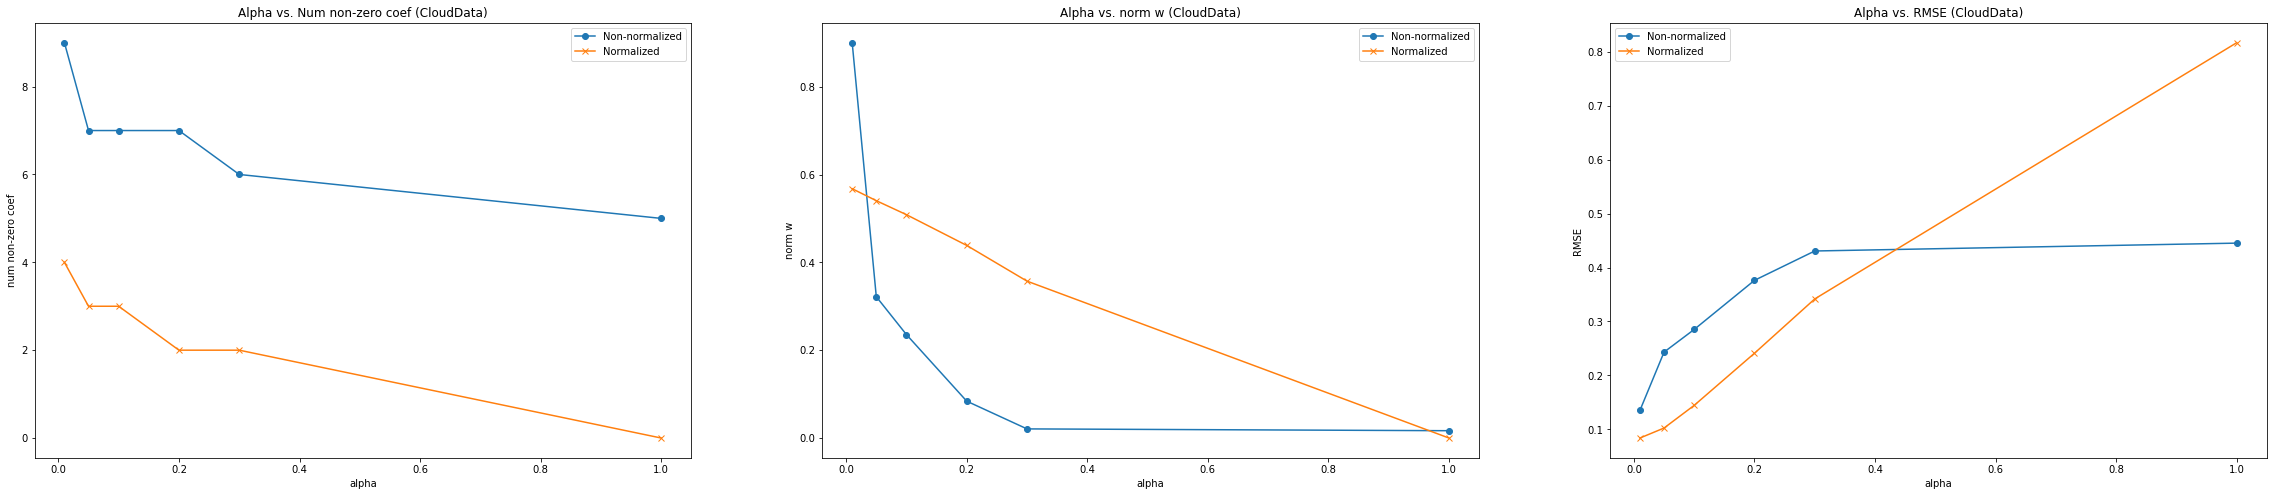

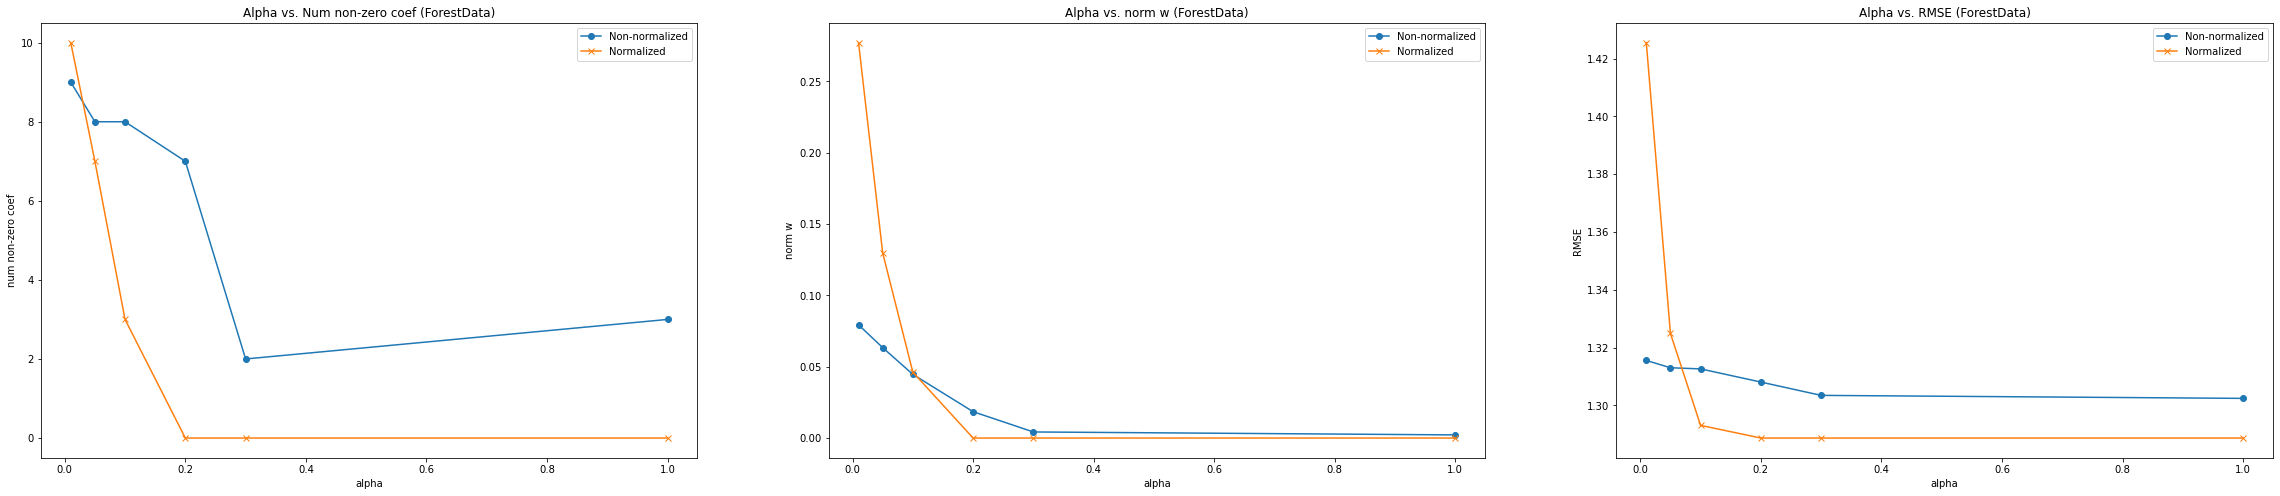

In [9]:
alphas = [0.01, 0.05, 0.1, 0.2, 0.3, 1.0]
# Workspace 1.4
#BEGIN 
#code here

for dataset in [cloud_data, forest_data]:
    
    non_zero_coef = {
        'regular': [],
        'normalized': []
    }
    
    norm_w = {
        'regular': [],
        'normalized': []
    }
    
    RMSE = {
        'regular': [],
        'normalized': []
    }
    
    for alpha in alphas:
        lasso = Lasso(alpha=alpha, normalize=False)
        non_zero_coef_curr, norm_w_curr = lasso.fit(dataset.train_x, dataset.train_y)
        RMSE_curr = lasso.evaluate(dataset.test_x, dataset.test_y)
        
        non_zero_coef['regular'].append(non_zero_coef_curr)
        norm_w['regular'].append(norm_w_curr)
        RMSE['regular'].append(RMSE_curr)
        
        lasso_norm = Lasso(alpha=alpha, normalize=True)
        non_zero_coef_curr, norm_w_curr = lasso_norm.fit(dataset.train_x, dataset.train_y)
        RMSE_curr = lasso_norm.evaluate(dataset.test_x, dataset.test_y)
        
        non_zero_coef['normalized'].append(non_zero_coef_curr)
        norm_w['normalized'].append(norm_w_curr)
        RMSE['normalized'].append(RMSE_curr)
    
    
    fig, ax = plt.subplots(1, 3, figsize=(40, 8))
    
    ax[0].plot(alphas, non_zero_coef['regular'], marker='o', label='Non-normalized')
    ax[0].plot(alphas, non_zero_coef['normalized'], marker='x', label='Normalized')
    ax[0].set_xlabel('alpha')
    ax[0].set_ylabel('num non-zero coef')
    ax[0].set_title(f'Alpha vs. Num non-zero coef ({dataset.__class__.__name__})')
    ax[0].legend()
    
    ax[1].plot(alphas, norm_w['regular'], marker='o', label='Non-normalized')
    ax[1].plot(alphas, norm_w['normalized'], marker='x', label='Normalized')
    ax[1].set_xlabel('alpha')
    ax[1].set_ylabel('norm w')
    ax[1].set_title(f'Alpha vs. norm w ({dataset.__class__.__name__})')
    ax[1].legend()
    
    ax[2].plot(alphas, RMSE['regular'], marker='o', label='Non-normalized')
    ax[2].plot(alphas, RMSE['normalized'], marker='x', label='Normalized')
    ax[2].set_xlabel('alpha')
    ax[2].set_ylabel('RMSE')
    ax[2].set_title(f'Alpha vs. RMSE ({dataset.__class__.__name__})')
    ax[2].legend()

#END

1.5 *[5 points]* (Write-up) Compare the two algorithms on each data set: compare the number of non-zero coordinates of Ridge vs Lasso and their MSE on each dataset.
Which type of regression is better for each dataset? When does normalization improve the regression?

# Workspace 1.5

The number of non-zero coefficients is less in both datasets for Ridge regression, which makes sense, as that algorithm cannot get the coefficients down to zero. The RMSE on Cloud data is higher for Lasso regression, and it's close to equal between the regression types on Forest data. It seems that Ridge is better on Cloud data, and the performance is closer to equal on Forest data. Normalization improves Ridge regression's performance on both datasets, but doesn't seem to have as significant of an effect on Lasso regression's performance.

Lasso is expected to have higher level of sparsity compared to Ridge. On the other hand, when the number of features is very large
(larger than the sample size), Lasso can struggle at picking the right features.
Elastic Net try to combine both types of regularization to get the best of both worlds by minimizing:

\begin{align}
\frac{1}{2N} \sum_i ||y_i - \mathbf{w}^Tx_i -b||^2_2 + \alpha\beta||\mathbf{w}||_1 + \frac{\alpha}{2}(1 - \beta)||\mathbf{w}||^2_2
\end{align}

where $\beta\in[0,1]$ is the $l_1$ ratio ($\beta=1$ for Lasso and $\beta=0$ for Ridge).

We'll be using ElasticNet solver from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html).

- 1.6 *[5 points]* Complete ElasticNet regression class `Elastic` by implementing fit and evaluate methods with the same signature as Lasso and Ridge.

In [10]:
from sklearn.linear_model import ElasticNet


class Elastic(object):
    def __init__(self, alpha, beta=0.5, normalize=False):
        """
        :param alpha: regularization parameter
        :param beta: l1_ratio for ElasticNet
        :param normalize: normalization flag
        """
        self.alpha = alpha
        self.beta = beta
        self.normalize = normalize
        self.scaler = StandardScaler()
        self._model = ElasticNet(alpha=alpha, l1_ratio=beta)
        self.coef_ = None
        self.intercept = None

    def fit(self, X, y):
        """
        fit self._model using the provided data and store the coef and intercept in self.coef_ and self.intercept
        Calculate the number of non-zero coefficients in the model weights and the norm using np.linalg.norm
        :param X: training features (n_samples, n_features)
        :param y: target values (n_samples)
        :return: tuple (number of non-zeros coefficients of w, norm of w)
        """

        num_nonzero_coefs, coef_norm = 0, 0
        # Workspace 1.6.a
        # TO DO: Complete Elastic Net
        # TO DO: save w and b in self.coef_ and self.intercept respectively
        #BEGIN 
        #code here
        
        if self.normalize:
            X = self.scaler.fit_transform(X)
                
        self._model.fit(X, y)
        
        self.coef_ = self._model.coef_
        self.intercept = self._model.intercept_
        
        num_nonzero_coefs = np.count_nonzero(self.coef_)
        coef_norm = np.linalg.norm(self.coef_)
        
        #END
        return num_nonzero_coefs, coef_norm

    def evaluate(self, test_x, test_y):
        """
        Compute Root mean square error (RMSE) between the predicted values and the actual values  of the test data
        :param test_x: test features
        :param test_y: test target
        :return: RMSE
        """
        
        if self.normalize:
            test_x = self.scaler.transform(test_x)
        
        # Workspace 1.6.b
        #BEGIN 
        #code here
        
        predicted_values = []
        
        for row in test_x:
            y_hat = np.sum(self.coef_ * row) + self.intercept
            predicted_values.append(y_hat)
            
        # to get RMSE, do (predicted - actual)^2, sum across num_samples, divide that by num_samples, take square root of all of that
        RMSE = 0
        for i in range(len(test_y)):
            RMSE += (predicted_values[i] - test_y[i])**2
            
        RMSE /= len(test_y)
        
        root_mean_squared_error = np.sqrt(RMSE)
        
        #END
        return root_mean_squared_error

In [11]:
# Tests cell, do not remove

# Test unnormalized ElasticNet
coef_raw = np.array([53.27862827, 10.94209836, 33.96771899])
intercept_raw = -7.796083758223746
reg = Elastic(alpha=2, beta=0.5, normalize=False)
reg.fit(sanity_X, sanity_y)
assert np.alltrue(np.isclose(coef_raw, reg.coef_, atol=1e-5)) and np.isclose(intercept_raw, reg.intercept, atol=1e-5)
# Test normalized Elastic
coef_norm = np.array([48.11601119, 14.15394196, 38.74380055])
intercept_norm = -7.502412860000006
reg = Elastic(alpha=2, beta=0.5, normalize=True)
reg.fit(sanity_X, sanity_y)
assert np.alltrue(np.isclose(coef_norm, reg.coef_, atol=1e-5)) and np.isclose(intercept_norm, reg.intercept, atol=1e-5)

- 1.7 *[5 points]* For each of the datasets, produce 3 plots as a function of $\alpha$ that compares normalized versus non-normalized ElasticNet:
    - The number non-zero coefficients
    - The norm of $\mathbf{w}$
    - The test RMSE

Use $\alpha = 0.01, 0.05, 0.1, 0.2, 0.3, 0.5 , 1.0$ and $\beta= 0.5$.

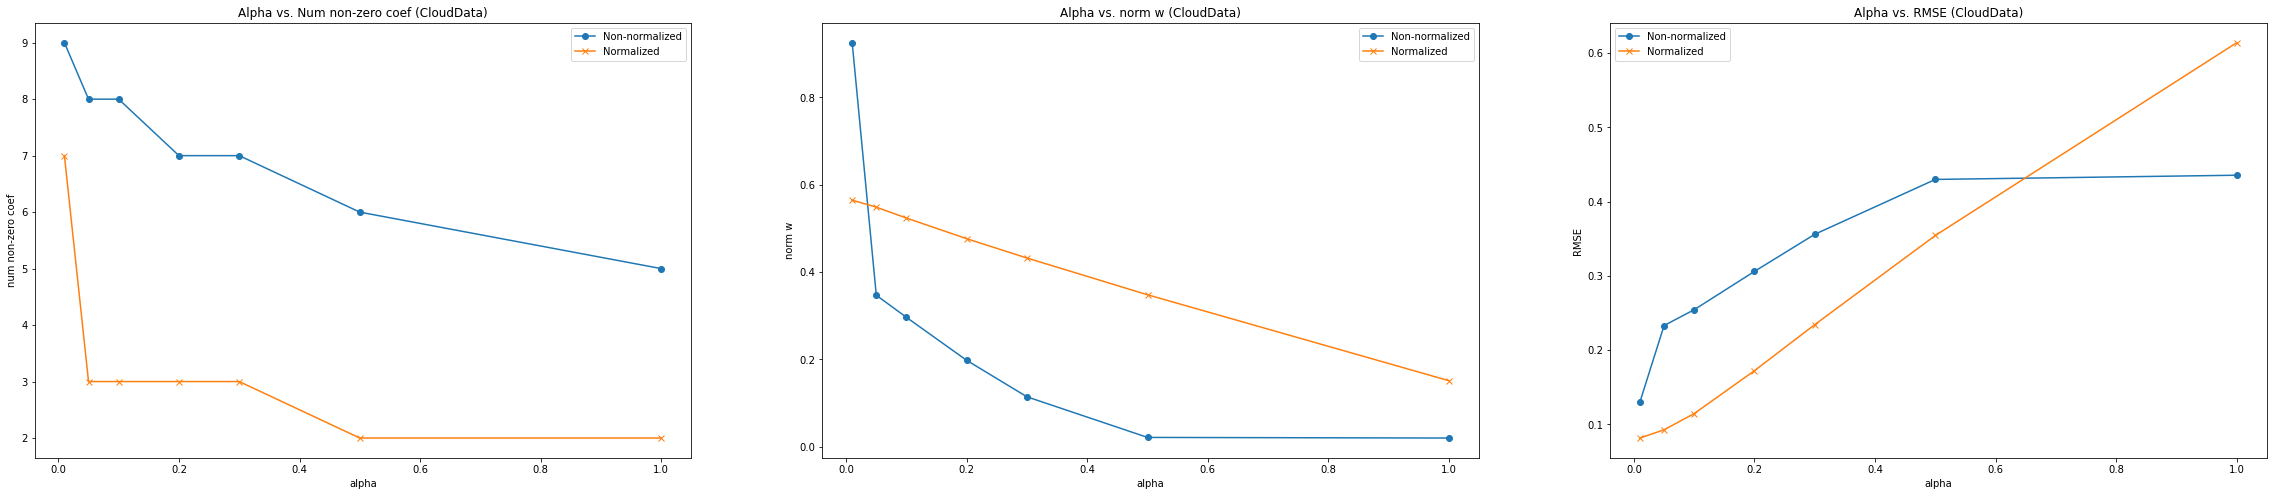

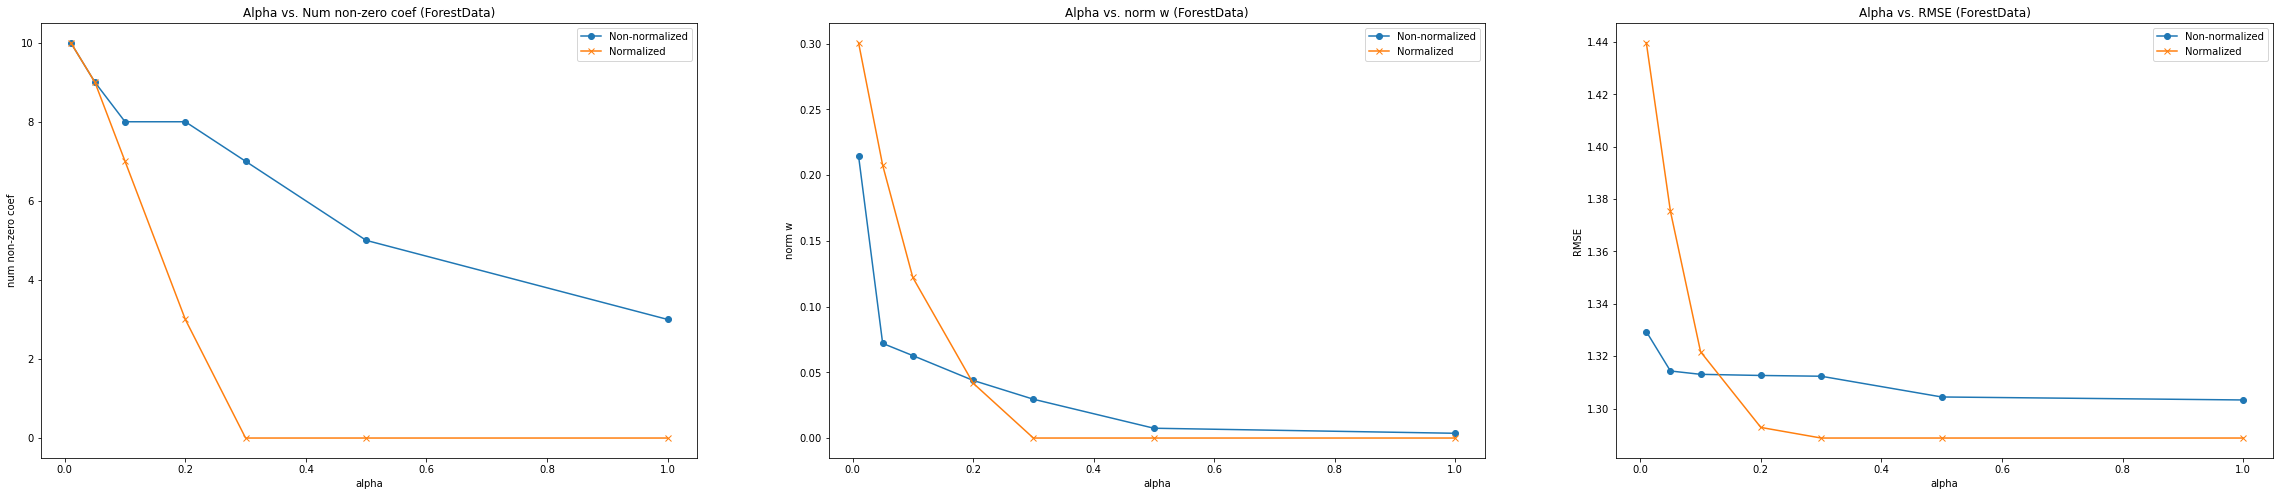

In [12]:
alphas = [ 0.01, 0.05, 0.1, 0.2, 0.3, 0.5 , 1.0]
beta = 0.5
# Workspace 1.7
#BEGIN 
#code here

for dataset in [cloud_data, forest_data]:
    
    non_zero_coef = {
        'regular': [],
        'normalized': []
    }
    
    norm_w = {
        'regular': [],
        'normalized': []
    }
    
    RMSE = {
        'regular': [],
        'normalized': []
    }
    
    for alpha in alphas:
        elastic = Elastic(alpha=alpha, normalize=False)
        non_zero_coef_curr, norm_w_curr = elastic.fit(dataset.train_x, dataset.train_y)
        RMSE_curr = elastic.evaluate(dataset.test_x, dataset.test_y)
        
        non_zero_coef['regular'].append(non_zero_coef_curr)
        norm_w['regular'].append(norm_w_curr)
        RMSE['regular'].append(RMSE_curr)
        
        elastic_norm = Elastic(alpha=alpha, normalize=True)
        non_zero_coef_curr, norm_w_curr = elastic_norm.fit(dataset.train_x, dataset.train_y)
        RMSE_curr = elastic_norm.evaluate(dataset.test_x, dataset.test_y)
        
        non_zero_coef['normalized'].append(non_zero_coef_curr)
        norm_w['normalized'].append(norm_w_curr)
        RMSE['normalized'].append(RMSE_curr)
    
    
    fig, ax = plt.subplots(1, 3, figsize=(40, 8))
    
    ax[0].plot(alphas, non_zero_coef['regular'], marker='o', label='Non-normalized')
    ax[0].plot(alphas, non_zero_coef['normalized'], marker='x', label='Normalized')
    ax[0].set_xlabel('alpha')
    ax[0].set_ylabel('num non-zero coef')
    ax[0].set_title(f'Alpha vs. Num non-zero coef ({dataset.__class__.__name__})')
    ax[0].legend()
    
    ax[1].plot(alphas, norm_w['regular'], marker='o', label='Non-normalized')
    ax[1].plot(alphas, norm_w['normalized'], marker='x', label='Normalized')
    ax[1].set_xlabel('alpha')
    ax[1].set_ylabel('norm w')
    ax[1].set_title(f'Alpha vs. norm w ({dataset.__class__.__name__})')
    ax[1].legend()
    
    ax[2].plot(alphas, RMSE['regular'], marker='o', label='Non-normalized')
    ax[2].plot(alphas, RMSE['normalized'], marker='x', label='Normalized')
    ax[2].set_xlabel('alpha')
    ax[2].set_ylabel('RMSE')
    ax[2].set_title(f'Alpha vs. RMSE ({dataset.__class__.__name__})')
    ax[2].legend()

#END

1.8 *[5 points]* What are the cons and pros of each of three types of regressions we have implemented?

# Workspace 1.8

Lasso and Elastic both push coefficients down toward zero, allowing feature selection, while Ridge doesn't. This can be viewed as either a pro or con depending on the problem at hand. If it is desired that all features are kept with some degree of importance, Ridge's lack of feature selection would be a pro, but if we desire to narrow down the feature set, it would be a con. An additional consideration regarding Ridge is its trade-off of variance for bias. Depending on the data in question, that tradeoff may be of benefit, but otherwise would be a negative. Lastly, Elastic is more computationally expensive, which could be a downside depending on the needs of the application.

***
## Problem 2: Logistic Regression for Binary Classification (35 points)

The second part of this assignment will be dealing with Logistic Regression.
While the name "regression" suggests otherwise, Logistic Regression is actually used for classification.
It's a regression problem because the targets are the continuous likelihoods of the outcomes.

Our dataset is a subset of the MNIST dataset, which has a higher resolution compared to the sklearn's digits data seen in HW1.

In this problem you'll implement a Logistic Regression classifier to take drawings of either an eight
or a nine and output the corresponding label.

In [13]:
class BinaryMNIST:
    """
    Class to store MNIST data for images of 9 and 8 only
    """
    def __init__(self, location='./data/mnist.pklz'):
        # You shouldn't have to modify this class
        # Load the dataset
        with gzip.open(location, 'rb') as f:
            self.train_x, self.train_y, self.test_x, self.test_y = pickle.load(f)

        train_indices = np.where(self.train_y > 7)
        self.train_x, self.train_y = self.train_x[train_indices], self.train_y[train_indices]
        self.train_y = self.train_y - 8

        test_indices = np.where(self.test_y > 7)
        self.test_x, self.test_y = self.test_x[test_indices], self.test_y[test_indices]
        self.test_y = self.test_y - 8

binary_mnist = BinaryMNIST()

Logistic Regression is about minimizing the negative log likelihood objective defined as:
\begin{align}
\textrm{NLL}(\mathbf{w}) = -\frac{1}{N}\sum_{i=1}^N \left[y_i \log \sigma(\mathbf{w}^T{x_i}) + (1-y_i)\log(1 - \sigma(\mathbf{w}^Tx_i))\right]
\end{align}

You might be wondering: where is the intercept?
We're including the intercept in $(x_i)_i$ since we'll be adding a constant column to the $(x_i)_i$.
We will call it the zero-th column and the intercept will be $\mathbf{w}_0$.

$\sigma$ is the sigmoid function seen in class.

The gradient of $NLL$ w.r.t $\mathbf{w}$ is:

\begin{align}
\frac{\partial \textrm{NLL}}{\partial \mathbf{w}} = \frac{1}{N} \sum_i \left[\sigma(\mathbf{w}^Tx_i)-y_i)\right]x_i
\end{align}

- 2.1 *[2.5 points]* Finish the `score` function to return the output of applying
the dot product of the weights with the input parameter

- 2.2 *[2.5 points]* Finish the `sigmoid` function to return the output of applying the sigmoid function to the calculated score

- 2.3 *[2.5 points]* Finish the `compute_gradient` function to return the derivative of the cost w.r.t. the weights

- 2.4 *[5 points]* Finish the `batch_update` function so that it performs batch gradient descent using the provided batch data

- 2.5 *[5 points]* Finish the `fit` function so that it performs several training epochs and returns the Recall score on
the validation data at the end of each epoch.

In [14]:
from sklearn.metrics import recall_score

class LogisticRegression:

    def __init__(self, eta = 0.1, alpha=0):
        """
        Create a logistic regression classifier
        :param eta: Learning rate
        :param alpha: We will use this parameter later (IN BONUS)
        """

        self.w = None # uninitialized w
        self.eta = eta # learning rate
        self.alpha = alpha # regularization / penalty term (USED IN BONUS)

    def score(self, x):
        """
        :param x: This can be a single training example or it could be n training examples
        :return score: Calculate the score that you will plug into the logistic function
        """

        # Workspace 2.1
        # TO DO: Compute the score to be fed to the sigmoid function
        #BEGIN 
        #code here
        
#         print(np.shape(x), np.shape(self.w))
        
        return x @ self.w
        
        #END


    def sigmoid(self, score, threshold=25.0):
        """
        :param score: Either a real valued number or a vector to convert into a number between 0 and 1
        :param threshold : Capping activations at to 25 prevent overflow of np.exp() function.
        return sigmoid function result.
        :return sigmoid: Calculate the output of applying the sigmoid function to the score. This could be a single
        value or a vector depending on the input.
        """
        # Workspace 2.2
        # TO DO: Complete this function to return the output of applying the sigmoid function to the score
        #BEGIN 
        #code here
        
        # idea for using clip found here: https://note.nkmk.me/en/python-numpy-clip/#:~:text=To%20limit%20the%20values%20of,~%201.0%20or%200%20~%20255%20.
        score = np.clip(score, a_min=-threshold, a_max=threshold)
        
        return 1/(1 + np.exp(-score))
        
        #END

    def compute_gradient(self, x, h, y):
        """
        :param x: Feature vector
        :param h: the sigmoid of the scores computed from x
        :param y: real class label
        :return gradient: Return the derivative of the cost w.r.t to the weights. Don't forget to average by batch_size
        """

        # Workspace 2.3
        # TO DO: Finish this function to compute the gradient
        #BEGIN 
        #code here
        
        batch_size = len(x)
        num_features = len(x[0])
        
        gradient = np.zeros(num_features)
        for i in range(batch_size):
            features = x[i]
            y_hat = h[i]
            gradient += (y_hat - y[i]) * features
            
        return gradient/batch_size
        
        #END

    def batch_update(self, batch_x, batch_y):
        """
        Single self.w update using the batch.
        :param batch_x: NumPy array of features (includes the constant feature at position 0)
        :param batch_y: Numpy array of target values (size : size of batch )
        :return: nothing
        """

        # Workspace 2.4
        #BEGIN 
        #code here
        
        score = self.score(batch_x)
        sigmoid = self.sigmoid(score, 25)
        gradient = self.compute_gradient(batch_x, sigmoid, batch_y)
        
        self.w -= self.eta * gradient
        
        #END

    def fit(self, X, y, epochs=1, batch_size=1, validation_X=None, validation_y=None):
        """
        :param X: training features
        :param y: training labels
        :param epochs: number of epochs
        :param batch_size: size of batch for gradient update
        :param validation_X: validation rows, should default to training data if not provided
        :param validation_y: validation labels
        :return: metric value at the end of each epoch on validation data
        """

        if validation_X is None:
            validation_X, validation_y = X, y
        metrics = []
        # Workspace  2.5
        # TO DO: Process x to append the zero-th constant column and call self.optimize
        # TO DO: Compute average recall on the validation data at the end of each apoch
        # HINT: make sure to initialize w only once since fit might be called several times
        #BEGIN 
        #code here
        
        constant_col = np.ones(len(X))
        # idea for using insert found here: https://stackoverflow.com/questions/47125884/how-to-insert-zeros-between-elements-in-a-numpy-array
        X = np.insert(X, 0, constant_col, axis=1)
        
        if self.w is None:
            self.w = np.random.randn(len(X[0]))
        
        for _ in range(epochs):
            self.optimize(X, y, batch_size)
            predictions = self.predict(validation_X)
            metrics.append(recall_score(validation_y, predictions))
        
        #END
        return np.array(metrics)
    
    def predict(self, test_x):
        """
        :param test_x: n rows to predict on
        :return: n predicted labels
        """
        X = np.concatenate([np.ones((test_x.shape[0],1)), test_x], axis=1)
        return np.round(self.sigmoid(self.score(X))).astype(int)

    def optimize(self, X, y, batch_size):
        """
        Perform one epoch batch gradient on shuffled data
        :param X: The training data  with zero-th column
        :param y: target values
        :param batch_size: batch_size of the batch_update
        :return: None
        """
        indices = np.random.permutation(len(X))
        for i in range(0, X.shape[0], batch_size):
            batch_x = X[indices[i:i+batch_size]]
            batch_y = y[indices[i:i+batch_size]]
            self.batch_update(batch_x, batch_y)


In [15]:
# test cell, do no remove

After completing the class above, loop over the training data and perform batch training with `batch_size=1`for 10 epochs,
and five different values of eta range [.0001, .01, .1, .5, 1]. Train your model and do the following:

- 2.6 *[5 points]* Create a new classifier object and Using the `fit` method, plot the recall trend for the different values of eta
on the training data. (reset random seed for each loop to mitigate the randomness effect)

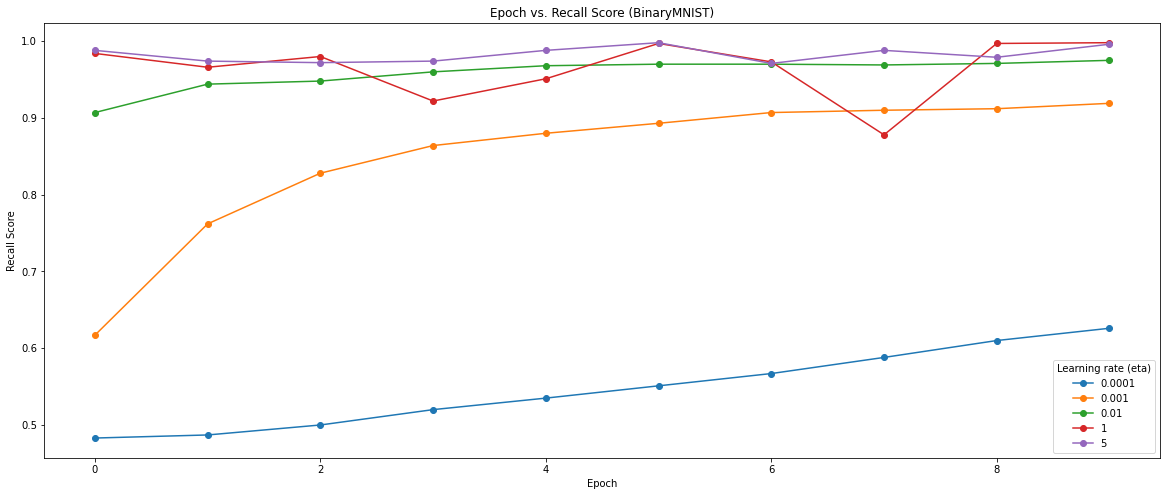

In [16]:
etas = [.0001,.001,.01, 1, 5]

fig, ax = plt.subplots(figsize=(20, 8))

for eta in etas:
    np.random.seed(42) # Reset randomness
    # Workspace 2.6
    #BEGIN 
    #code here
    
    LR = LogisticRegression(eta=eta)
    recall_metrics = LR.fit(binary_mnist.train_x, binary_mnist.train_y, epochs=10, batch_size=1)
    ax.plot(range(10), recall_metrics, marker='o', label=f'{eta}')
    
    #END
ax.set_xlabel('Epoch')
ax.set_ylabel('Recall Score')
ax.set_title(f'Epoch vs. Recall Score ({binary_mnist.__class__.__name__})')
plt.legend(title='Learning rate (eta)')
plt.show()

- 2.7 *[2.5 points]* Create a new classifier object and Using the `fit` method, plot the recall on the test data as function eta.
(reset random seed for each loop to mitigate the randomness effect)

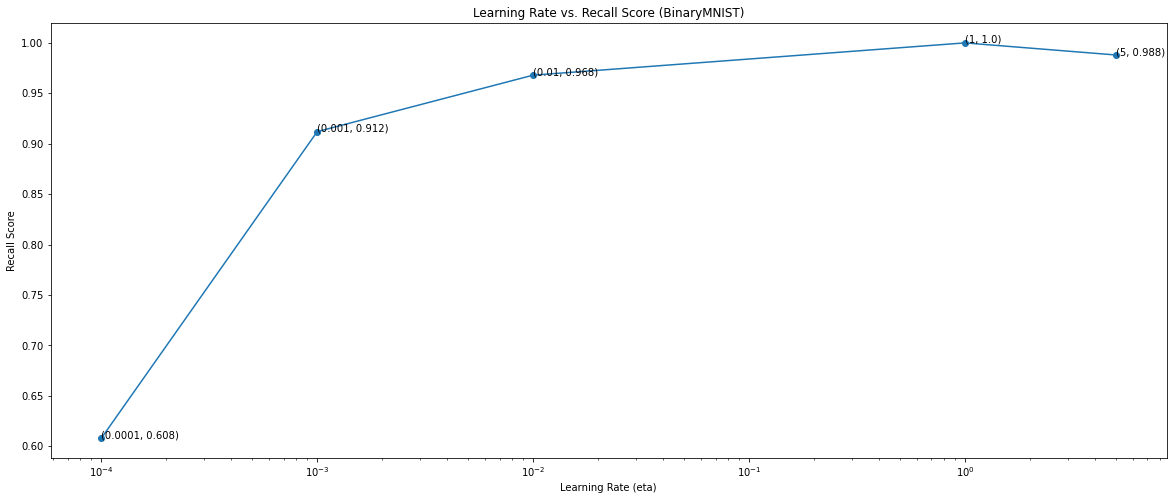

In [17]:
etas = [.0001,.001,.01, 1, 5]

data = []

fig, ax = plt.subplots(figsize=(20, 8))

for eta in etas:
    np.random.seed(42)
    # Workspace 2.7
    #BEGIN 
    #code here
    
    LR = LogisticRegression(eta=eta)
    _ = LR.fit(binary_mnist.train_x, binary_mnist.train_y, epochs=10, batch_size=1)
    predictions = LR.predict(binary_mnist.test_x)
    recall = recall_score(binary_mnist.test_y, predictions)
    data.append(recall)
    
    #END
ax.plot(etas, data, marker='o')
for i in range(len(etas)):
    plt.text(etas[i], data[i], f'({etas[i]}, {data[i]})')
ax.set_xscale('log')
ax.set_xlabel('Learning Rate (eta)')
ax.set_ylabel('Recall Score')
ax.set_title(f'Learning Rate vs. Recall Score ({binary_mnist.__class__.__name__})')
plt.show()

This time we want to analyze the effect of varying the batch size. We fix `eta=0.1` and `epochs=10` and we want to
examine the recall on the test set at the end of the training for `batch_size` in [1, 2, 4, 8, 12, 16].

2.8 *[5 points]* Produce a plot of the recall at the end of the training as a function of the batch size. Reset the random generator before each you compute the recalls for each batch size.


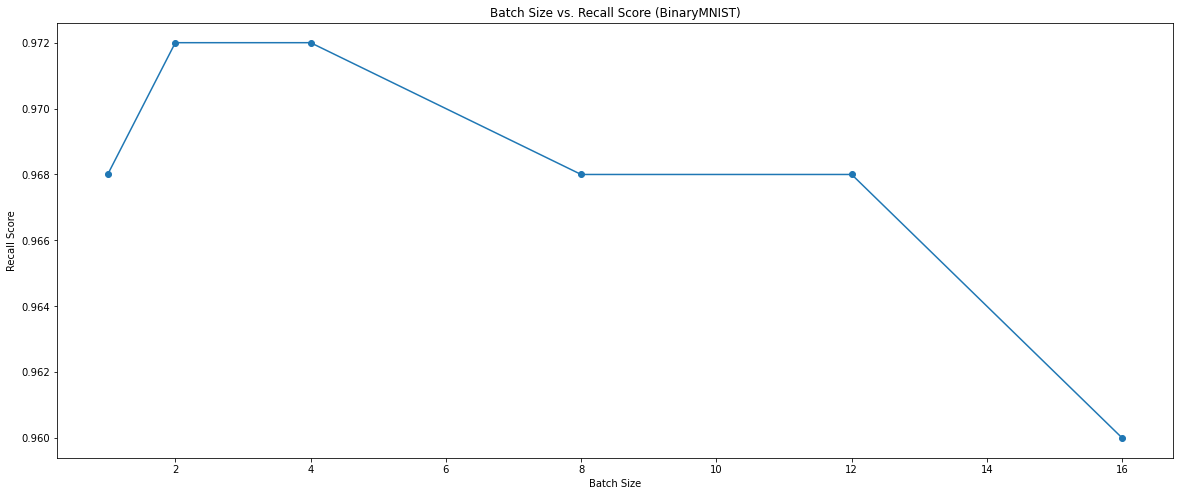

In [18]:
batch_sizes= [1, 2, 4, 8, 12, 16]
data = []

fig, ax = plt.subplots(figsize=(20, 8))

for batch_size in batch_sizes:
    np.random.seed(42)
    # Workspace 2.8
    #BEGIN 
    #code here
    LR = LogisticRegression(eta=.1)
    _ = LR.fit(binary_mnist.train_x, binary_mnist.train_y, epochs=10, batch_size=batch_size)
    predictions = LR.predict(binary_mnist.test_x)
    recall = recall_score(binary_mnist.test_y, predictions)
    data.append(recall)
    
    #END
ax.plot(batch_sizes, data, marker='o')
ax.set_xlabel('Batch Size')
ax.set_ylabel('Recall Score')
ax.set_title(f'Batch Size vs. Recall Score ({binary_mnist.__class__.__name__})')
plt.show()

2.9 *[5 points]* How does the learning rate (eta) and the number of epochs in the performance of the classifier.

# Workspace 2.9

The learning rate and number of epochs both have positive correlations to classifier performance (as eta and number of epochs each increase, recall score also increases).

2.10 (Bonus) *[5 points]* Since we're done with the binary regression, we will try to add Ridge regularization:
\begin{align}
\textrm{NLL}(w) = -\frac{1}{N}\sum_{i=1}^N \left[y_i \log \sigma(\mathbf{w}^T{x_i}) + (1-y_i)\log(1 - \sigma(\mathbf{w}^Tx_i))\right] + \alpha {||\mathbf{w}||^2}_{\geq1}
\end{align}

This is exactly what we will be using the `alpha` parameter in `LogisticRegression` for.
First, write the gradient formula in the cell below and edit your `compute_gradient` to account for the regularization term. Note that the regularization $||w||^2$ does not apply to the intercept $\mathbf{w}_0$

# Workspace 2.10

Write-up answer here



## Problem 3: Logistic Regression for Multiclass Classification (25)

You will now create a classifier that is commonly referred to as _One Versus All_ Logistic Regression,
where a binary classifier will be trained to identify a single class. The prediction is performed by assigning the label
of the classifier that is most confident in its prediction (the highest score).

The dataset will be a restricted version of the MNIST dataset which digits 3,7,8,9. You are free to use the functions you created above as needed.

In [19]:
class MNIST:
    """
    Class to store MNIST data for images of 3,7,8,9
    """
    def __init__(self, location="data/mnist.pklz"):
        # You shouldn't have to modify this class
        # Load the dataset
        with gzip.open(location, 'rb') as f:
            self.train_x, self.train_y, self.test_x, self.test_y = pickle.load(f)
mnist = MNIST()

- 3.1 *[2.5 points]* Complete `one_hot_encoding`to transform your integer labels into a set of binary features via one-hot encoding.
* 3.2 *[2.5 points]* Complete `normalize_data` to normalize your features. You can use `StandardScaler`
* 3.3 *[5 points]* Complete `predict` method to return the predicted label using the scores from each class classifier
* 3.4 *[2.5 points]* Complete `evaluate` to return the weighted average recall (WAR) on the validation data (use `recall_score`)
* 3.5 *[5 points]* Complete `fit` function to fit all 4 classifiers with their corresponding labels and compute the WAR at the end of each epoch

In [43]:
class OneVersusAll(object):

    def __init__(self, eta = 0.1, alpha=0):
        self.eta = eta # Learning Rate
        self.classifiers = [] # Array of LogisticRegression classifiers
        self.label_to_index = {3:0, 7:1, 8:2, 9:3} # dictionary mapping MNIST labels to array indices 0 - 3
        self.index_to_label = {v:k for k,v in self.label_to_index.items()} # dictionary mapping array indices 0 - 3 
            # to MNIST labels
        self.alpha = alpha # regularization / penalty rate (USED IN BONUS)
        self.scaler = StandardScaler()
        self.fitted = False # Flag to store wether the model is already fitted to avoid fitting scaler more than once

    def one_hot_encoding(self, y):
        one_hot_encode = np.zeros((len(y), 4))
        # Workspace 3.1
        # TO DO: Represent the output vector y as a one hot encoding. Create a matrix of dimensions (m X 4)
        # where m = number of examples, and 4 for number of classes
        # if the class for the ith example is 7, then y[i][label_to_index[7]] = 1 and the for k != 1, y[i][k] = 0.
        #BEGIN 
        #code here
        
        for i in range(len(y)):
            one_hot_encode[i][self.label_to_index[y[i]]] = 1
        
        #END
        return np.array(one_hot_encode)

    def normalize_data(self, X):
        """
        Fit scaler if it hasn't been done yet and normalize X
        :param X: Raw features.
        :return: Normalized feautures
        """
        # Workspace 3.2
        # TO DO: Normalize the feature values of dataset X, you have to keep track of the mean and variance
        #BEGIN 
        #code here
        
        X = self.scaler.fit_transform(X)
        
        #END
        return X

    def predict(self, test_x):
        # Workspace 3.3
        # TO DO: Normalize test_x, process it and return the predicted label using the scores from classifiers
        #BEGIN 
        #code here
        
        predictions = []
        prob_predictions = np.zeros((len(test_x), len(self.classifiers)))
        
        test_x = self.normalize_data(test_x)
        constant_col = np.ones(len(test_x))
        test_x = np.insert(test_x, 0, constant_col, axis=1)
        
        for i, classifier in enumerate(self.classifiers):
            scores = classifier.score(test_x)
#             print(np.shape(self.scores))
            sig_scores = classifier.sigmoid(scores)
            prob_predictions[:,i] = sig_scores
            
        for row in prob_predictions:
            highest_prob_index = np.argmax(row)
            highest_prob_label = self.index_to_label[highest_prob_index]
            predictions.append(highest_prob_label)
        
        #END
        return predictions

    def evaluate(self, test_x, test_y):
        # Workspace 3.4
        #BEGIN 
        #code here
        
        predictions = self.predict(test_x)
        WAR = recall_score(test_y, predictions, average='weighted')
        
        #END
        return WAR

    def fit(self, X, y, batch_size=12, epochs=10, validation_X=None, validation_y=None):
        metrics = []
        if validation_X is None:
            validation_X, validation_y = X, y
        # Workspace 3.5
        # TO DO: Compute Weighted Average Recall at the end of each epoch
        # TO DO: Process training data and use it to fit self.classifiers and compute the metrics every epoch
        #BEGIN 
        #code here
        
        X = self.normalize_data(X)
        
        for i in range(4):
            self.classifiers.append(LogisticRegression(eta=self.eta))
        
        y = self.one_hot_encoding(y)
        
        for x in range(epochs):
#             print(x)
            for i, classifier in enumerate(self.classifiers):
                _ = classifier.fit(X, y[:,i], epochs=1, batch_size=batch_size)
            WAR = self.evaluate(validation_X, validation_y)
            metrics.append(WAR)
        
        #END
        return metrics


In [21]:
# This cell will be used for tests
# Do not remove

- 3.6 *[5 points]* Train `OneVersusAll` for 36 epochs using eta=0.1 and batch_size = 12. In the same figure, plot:
    - The WAR metric on the mnist training data at the end of each epoch
    - The WAR metric on the mnist test data at the end of each epoch

You might need to adapt LogisticRegression so that fit method can be called multiple times without
losing the weights from previous batch gradients.

For a fair comparison, call `np.random.seed(42)` before each `fit` to reset the random generator.

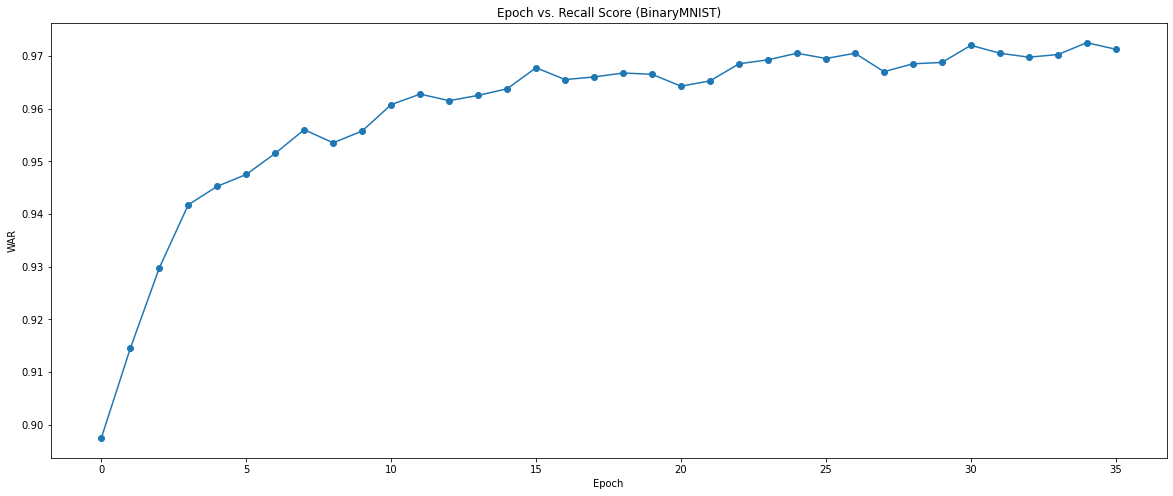

In [48]:
epochs = 36
eta = 0.1
batch_size = 12
# Workspace 3.6
#BEGIN 
#code here

fig, ax = plt.subplots(figsize=(20, 8))

OVA = OneVersusAll(eta=.1)
metrics_train = OVA.fit(mnist.train_x, mnist.train_y, batch_size=batch_size, epochs=epochs)

OVA_2 = OneVersusAll(eta=.1)
metrics_test = OVA_2.fit(mnist.train_x, mnist.train_y, batch_size=batch_size, epochs=epochs, validation_X=mnist.test_x, validation_y=mnist.test_y)

ax.plot(range(epochs), metrics_train, marker='o')
ax.plot(range(epochs), metrics_test, marker='o')
ax.set_xlabel('Epoch')
ax.set_ylabel('WAR')
ax.set_title(f'Epoch vs. Recall Score ({binary_mnist.__class__.__name__})')
plt.show()

#END

- 3.7 *[2.5 points]* Does the WAR improve as we train for more epochs on the two data partitions (train, test)? Why?

% Workspace 3.7

Write-up answer here

- 3.8 (Bonus)*[5 points]* Repeat 3.6 and 3.7 using Ridge regularization for the LogisticRegression classifiers with alpha=1. How does the regularization affect the performance on train VS test sets?

You have to answer 2.10 before you attempt this question.

In [ ]:
epochs = 36
eta = 0.1
batch_size = 12
alpha = 1.0
# Workspace 3.8 (code)
#BEGIN 
#code here

#END


% Workspace 3.8 (write up)

Write-up answer here